In [ ]:
import numpy as np

In [2]:
from ecoevocrm.consumer_resource_system import *
import ecoevocrm.viz as viz
from ecoevocrm.coarse_graining import *

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})

#

# Model parameters

## Traits

In [4]:
num_resources = 16
num_traits = num_resources

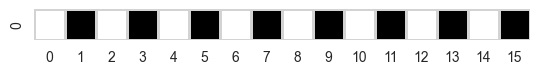

In [5]:
traits_init = np.zeros(num_resources)
traits_init[::-2] = 1
traits_init = traits_init.reshape((1, num_traits))
viz.matrix_plot(traits_init, vmin=0, cbar=False, linecolor='lightgray', linewidths=1)

In [6]:
N_init = np.ones(traits_init.shape[0])
N_init

array([1.])

## Costs

In [7]:
cost_baseline = 0.1
cost_pertrait = 0.5

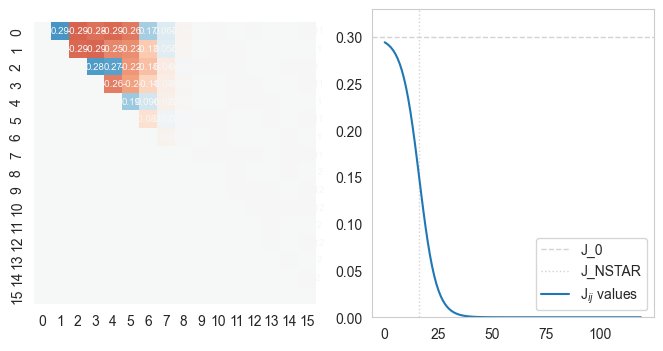

In [10]:
num_interactions = (num_traits**2 - num_traits)/2
J_0 = 0.3
J_NSTAR = 16
DELTA = 4
J_SEED  = 1
J_ORDER_POWER = 20
#----------
J = utils.random_matrix((num_resources, num_resources), 'tikhonov_sigmoid_ordered', 
                        args={'J_0': J_0, 'n_star': J_NSTAR, 'delta': DELTA}, triangular=True, diagonal=0,
                        shuffle=True, order_power=J_ORDER_POWER, seed=J_SEED)
#----------
fig, ax = plt.subplots(1, 2, figsize=(8, 4)) 
viz.matrix_plot(J, ax=ax[0], vmin=-0.5, vmax=0.5, cbar=False, annot=True, annot_kws={'size': 7, 'color': '#f7f7f7'})
ax[1].axhline(J_0, ls='--', color='lightgray', label='J_0', lw=1)
ax[1].axvline(J_NSTAR, ls=':', color='lightgray', label='J_NSTAR', lw=1)
ax[1].plot(range(len(J[J!=0])), np.sort(np.abs(J[J!=0]))[::-1], label="J${}_{ij}$ values")
ax[1].set_ylim(0, 0.33)
ax[1].legend()

In [11]:
total_interaction_bytrait = np.abs(J).sum(axis=1) + np.abs(J).sum(axis=0) - np.diag(np.abs(J))
rel_total_interaction_bytrait = total_interaction_bytrait / np.max(total_interaction_bytrait)
rel_total_interaction_bytrait

array([1.00000000e+00, 9.31128761e-01, 9.35370742e-01, 8.79923355e-01,
       8.25389409e-01, 7.29224950e-01, 4.57146456e-01, 1.64416704e-01,
       3.41363191e-02, 4.89862327e-03, 5.31082007e-04, 4.44419718e-05,
       2.88289559e-06, 1.45159374e-07, 5.67781917e-09, 1.72600304e-10])

##### "Suppressions" using cost adjustments via the cost_landscape dictionary:

In [12]:
cost_adjustments = {'11**************': 10.0,
                    '**************11': 10.0}

## Environment

In [13]:
T_total    = 1e6
dt_env     = 1e3

In [14]:
NOISE_ENV = 0 # 1e-9
SEED_ENV  = 1

In [15]:
influx_mean = np.ones(num_resources)
influx = utils.brownian_series(T=T_total, dt=dt_env, num_series=num_resources, y0=influx_mean, eta_std=NOISE_ENV,
                               eta_mean=0, lamda=1e-3, k=1e-8, v0=0, return_interp=True, seed=SEED_ENV)

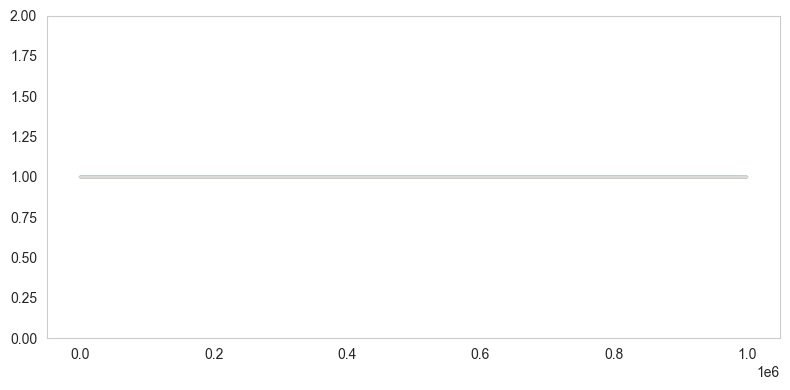

In [16]:
resource_colors = sns.color_palette('terrain', num_resources)
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
viz.interp_series_plot(influx, ax=ax, t_vals=np.arange(0, T_total, step=dt_env), colors=resource_colors)
ax.set_ylim(0, 2)
fig.tight_layout()

In [17]:
R_init = np.ones(num_resources)
R_init

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

# Community Simulation

In [18]:
SIM_SEED = 1

In [19]:
k = 1e9
m = 1e-9
delta = 1

In [20]:
community = Community(traits=traits_init, N_init=N_init, R_init=R_init, influx_rate=influx, decay_rate=delta,
                      cost_baseline=cost_baseline, cost_trait=cost_pertrait, cost_interaction=J, cost_landscape=cost_adjustments,
                      carrying_capacity=k, mutation_rate=m, seed=SIM_SEED)

In [21]:
community.run(T=T_total)

KeyError: '0101010101010101'

In [20]:
trait_weights = np.array([1/i**(1.0) for i in range(1, num_resources+1)])
trait_weights = trait_weights/np.sum(trait_weights)
trait_colors = np.array(sns.color_palette('turbo', num_resources))
# - - - -
_rng = np.random.RandomState(7114396)
_rng.shuffle(trait_colors)
# - - - -
# idx = np.empty(len(trait_colors), int)
# idx[0::2] = np.arange((len(trait_colors)+1)//2)          # 0,1,2,...
# idx[1::2] = -np.arange(1, len(trait_colors)//2 + 1)      # -1,-2,-3,...
# trait_colors = trait_colors[idx]
# - - - -
type_colors = []
for type_traits in community.type_set.traits:
    if np.array_equal(type_traits.ravel(), traits_init.ravel()):
        type_colors.append((0.75, 0.75, 0.75))
    else:
        mask = type_traits != 0  # convert to boolean mask
        if not np.any(type_traits):
            type_colors.append((0, 0, 0))  # or some default color
            continue
        w_masked = trait_weights[mask]
        c_masked = trait_colors[mask]
        combined = np.average(c_masked, axis=0, weights=w_masked)
        type_colors.append(tuple(combined))

<AxesSubplot: >

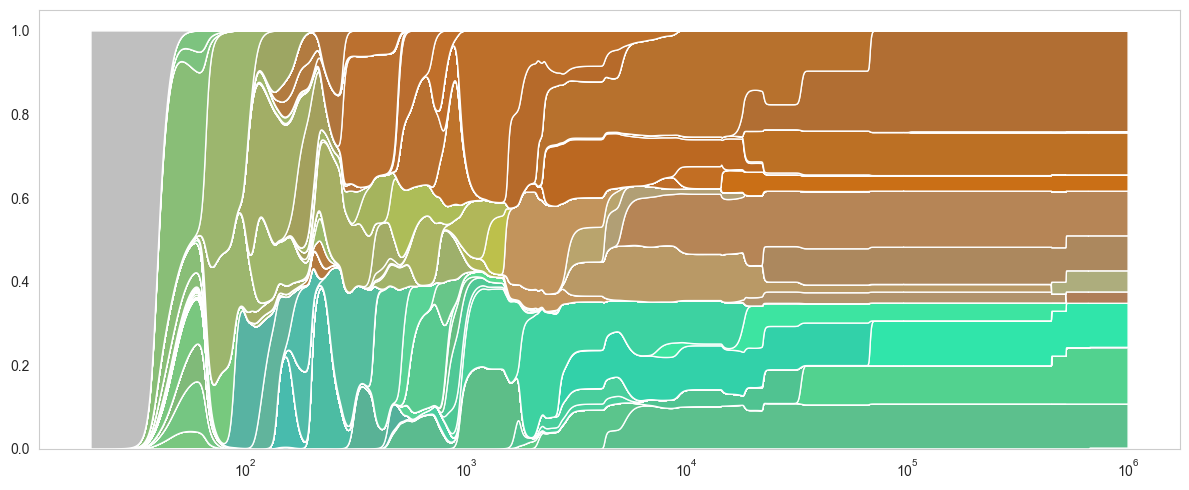

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
viz.abundance_plot(community, ax=ax, type_colors=type_colors, type_hatches=None, relative_abundance=True, stacked=True, baseline='sym', log_x_axis=True, t_min=20)

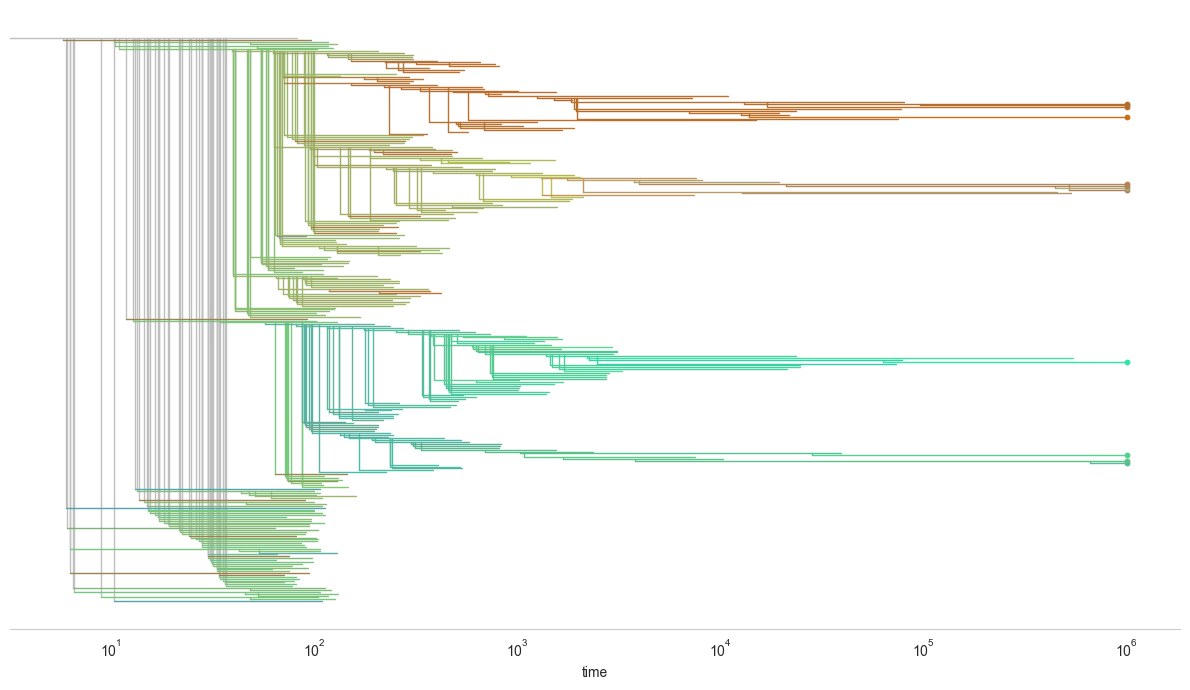

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
viz.phylogeny_plot(community, ax=ax, type_colors=type_colors, annot_lineageIDs=False, annot_traits=False, annot_extinct=False, annot_fontsize=8, log_x_axis=True)

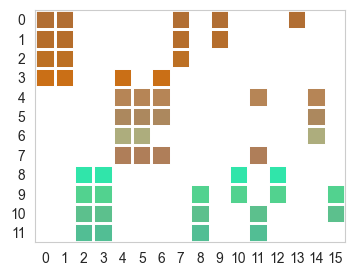

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(4, 10))
viz.attributes_plot(community.extant_type_set, ax=ax, type_colors=np.array(type_colors)[community.get_extant_type_indices()], annot_alpha=0)

In [24]:
community.N[community.extant_type_indices] / np.sum(community.N)

array([0.24112856, 0.00312873, 0.10023208, 0.03898021, 0.106869  ,
       0.08374219, 0.05051726, 0.02703101, 0.10537433, 0.13576579,
       0.10536266, 0.00186818])

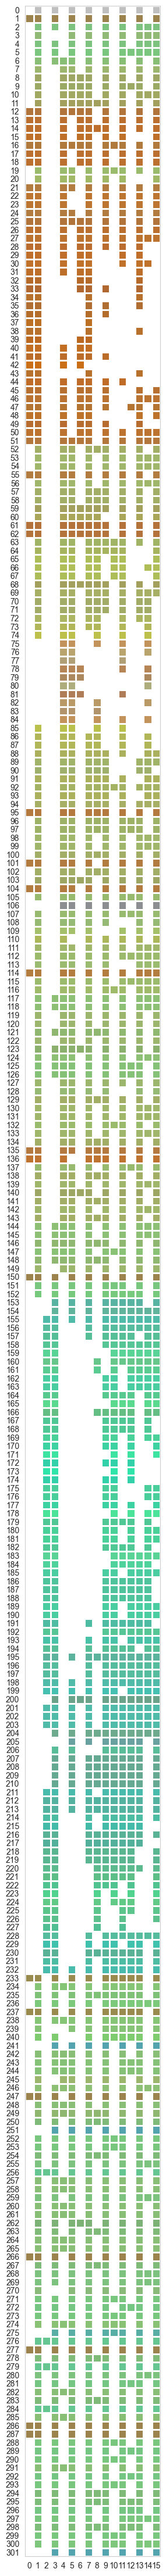

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(3, 500))
viz.attributes_plot(community.type_set, ax=ax, type_colors=np.array(type_colors)[:], annot_alpha=0)

(0.0, 2.0)

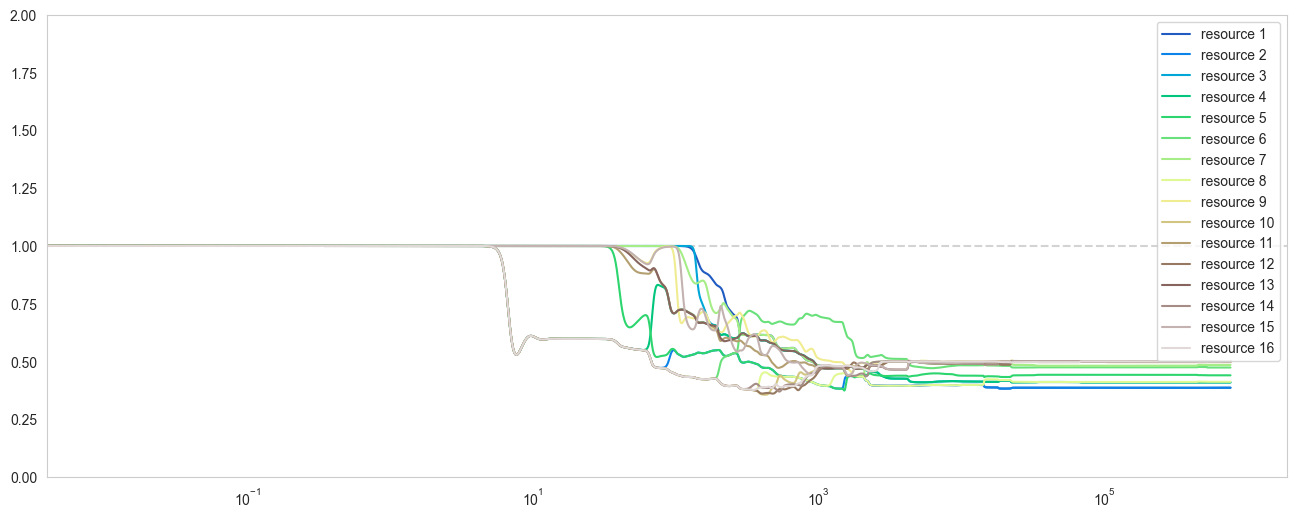

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(16, 6))
viz.resource_plot(community, ax=ax, log_x_axis=True)
ax.axhline(1, ls='--', color='lightgray', zorder=-99)
ax.set_ylim(0, 2)